The HOTS Logs website (https://hotslogs.com) has an API with a data dump of the past 30 days' worth of replays.

https://www.hotslogs.com/Info/API

It's the automated version of this reddit post: https://www.reddit.com/r/heroesofthestorm/comments/43q3jc/hots_logs_data_export_19_million_games/

That being said, this information is incredibly awesome! What kind of information can be gleaned from it?

In [84]:
import itertools
from multiprocessing import Pool

import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
replays = pd.read_csv("/home/brooks/data/hots/Replays.csv")

In [3]:
replays.head()

,ReplayID,GameMode(3=Quick Match 4=Hero League 5=Team League 6=Unranked Draft),MapID,Replay Length,Timestamp (UTC)
0,155936477,3,1007,00:25:04,8/27/2018 1:31:50 AM
1,155291732,3,1003,00:21:51,8/27/2018 1:31:52 AM
2,155676469,3,1001,00:24:09,8/27/2018 1:31:52 AM
3,155291738,3,1002,00:16:35,8/27/2018 1:32:00 AM
4,155291753,3,1019,00:26:01,8/27/2018 1:32:03 AM


Let's prep the data for analysis

In [4]:
replays.rename(
    {
        "ReplayID": "id",
        "GameMode(3=Quick Match 4=Hero League 5=Team League 6=Unranked Draft)": "game_mode",
        "MapID": "map_id",
        "Replay Length": "length",
        "Timestamp (UTC)": "timestamp",
    },
    axis=1,
    inplace=True,
)

The `length` column is currently just a string. If we want to plot it, we should turn it into a timedelta object.

In [5]:
replays["length"] = pd.to_timedelta(replays.length)

The `timestamp` column is still just a string. It needs to be in a date format that pandas understands in order to be useful.

In [6]:
%%time

with Pool() as pool:
    replays["timestamp"] = pool.map(pd.to_datetime, replays.timestamp)

CPU times: user 15.4 s, sys: 1.11 s, total: 16.5 s
Wall time: 8min 49s


In [7]:
replays.head()

,id,game_mode,map_id,length,timestamp
0,155936477,3,1007,00:25:04,2018-08-27 01:31:50
1,155291732,3,1003,00:21:51,2018-08-27 01:31:52
2,155676469,3,1001,00:24:09,2018-08-27 01:31:52
3,155291738,3,1002,00:16:35,2018-08-27 01:32:00
4,155291753,3,1019,00:26:01,2018-08-27 01:32:03


In [8]:
replays.iloc[0].timestamp

Timestamp('2018-08-27 01:31:50')

## When do people play?

In [9]:
games_per_day = replays.resample("D", on="timestamp").timestamp.count()

Text(0.5, 0, 'Date')

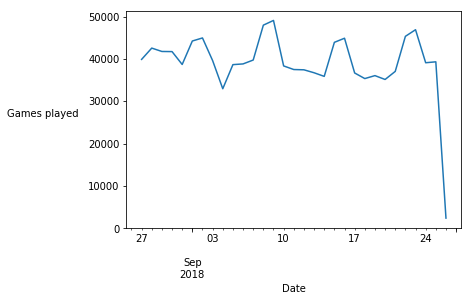

In [10]:
ax = games_per_day.plot()

ax.set_ylabel("Games played", rotation=0, labelpad=45)
ax.set_xlabel("Date")

Looks like people play anywhere from 30k to 50k games on any given day. Except on the last day? That doesn't look right.

In [11]:
replays.sort_values(by="timestamp").tail(1)

,id,game_mode,map_id,length,timestamp
791122,157198794,3,1016,00:24:07,2018-09-26 01:31:46


In [12]:
ls -l ~/data/hots

total 1385812
-rw-r--r-- 1 brooks brooks      3088 Oct 26 01:31  HeroIDAndMapID.csv
-rw-r--r-- 1 brooks brooks 382118435 Oct 27 11:26 'HOTSLogs Data Export Current.zip'
-rw-r--r-- 1 brooks brooks 979037223 Oct 26 02:02  ReplayCharacters.csv
-rw-r--r-- 1 brooks brooks  57903413 Oct 26 02:02  Replays.csv


Even though I downloaded this data on the 27th, it looks like the data only goes up to the first couple of hours on the 26th. Given this, it makes sense why the previous graph shows a drastic decrease in games played on the last day - because **we don't have a full days' worth of data**. If we were to omit games for the last day, we would see a much more accurate picture of games played.

In [13]:
replays = replays[replays.timestamp < "2018-09-26"]
games_per_day = replays.resample("D", on="timestamp").timestamp.count()

Text(0.5, 0, 'Date')

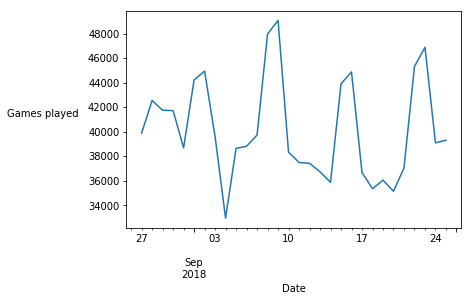

In [14]:
ax = replays.resample("D", on="timestamp").timestamp.count().plot()

ax.set_ylabel("Games played", rotation=0, labelpad=45)
ax.set_xlabel("Date")

That gives us a much better picture of things

Text(0.5, 1.0, 'Variance of games played per day')

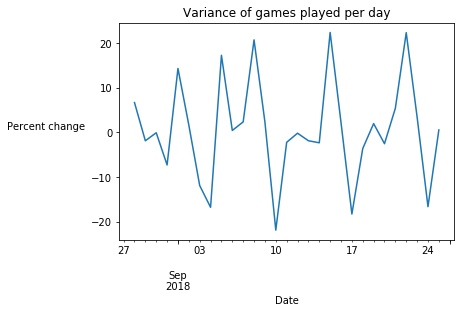

In [15]:
ax = games_per_day.pct_change().apply(lambda pct: pct * 100).plot()

ax.set_ylabel("Percent change", rotation=0, labelpad=45)
ax.set_xlabel("Date")
ax.set_title("Variance of games played per day")

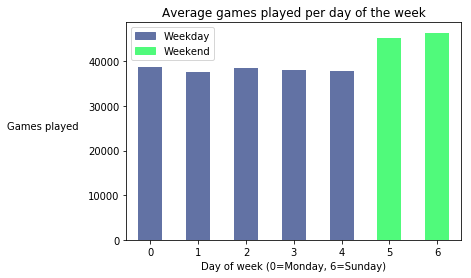

In [71]:
weekday_color = "#6272a4"
weekend_color = "#50fa7b"

ax = games_per_day.groupby(games_per_day.index.dayofweek).mean().plot.bar(
    rot=0,  # Let x labels be horizontal
    color=[weekday_color] * 5 + [weekend_color] * 2,
)

ax.set_title("Average games played per day of the week")
ax.set_xlabel("Day of week (0=Monday, 6=Sunday)")
ax.set_ylabel("Games played", rotation=0, labelpad=45)

ax.legend(handles=[
    mpatches.Patch(color=weekday_color, label="Weekday"),
    mpatches.Patch(color=weekend_color, label="Weekend"),
])

Not surprisingly, people play more games on the weekend than they do during the week.

## Match length
How long do matches last on average, and how does that vary depending on the map being played?

In [6]:
heroes_and_maps = pd.read_csv("/home/brooks/data/hots/HeroIDAndMapID.csv")

In [7]:
heroes_and_maps.columns = [column.lower() for column in heroes_and_maps.columns]

In [8]:
heroes_and_maps.head()

,id,name,group,subgroup
0,0,Unknown,NaN,NaN
1,1,Abathur,Specialist,Utility
2,2,Anub'arak,Warrior,Tank
3,3,Arthas,Warrior,Bruiser
4,4,Azmodan,Specialist,Siege


In [9]:
heroes_and_maps.tail()

,id,name,group,subgroup
101,1018,Pull Party,NaN,NaN
102,1019,Volskaya Foundry,NaN,NaN
103,1020,Industrial District,NaN,NaN
104,1021,Escape From Braxis,NaN,NaN
105,1022,Alterac Pass,NaN,NaN


In [10]:
match_lengths = (
    replays[["map_id", "length"]]
    .merge(heroes_and_maps[["id", "name"]],
        left_on="map_id",
        right_on="id",
    )
)

del match_lengths["map_id"]

In [31]:
match_lengths["length_mins"] = match_lengths.length.apply(lambda length: length.total_seconds() / 60)

In [33]:
match_lengths.head()

,length,id,name,length_mins
0,00:25:04,1007,Infernal Shrines,25.066667
1,00:21:15,1007,Infernal Shrines,21.250000
2,00:19:27,1007,Infernal Shrines,19.450000
3,00:25:16,1007,Infernal Shrines,25.266667
4,00:12:09,1007,Infernal Shrines,12.150000


Text(0.5, 0, 'Minutes')

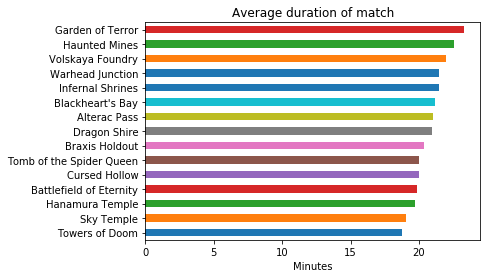

In [48]:
ax = (match_lengths
      .groupby("name")
      .length_mins
      .mean()
      .sort_values()
      .plot.barh()
)

ax.set_title("Average duration of match")
ax.set_ylabel("")
ax.set_xlabel("Minutes")

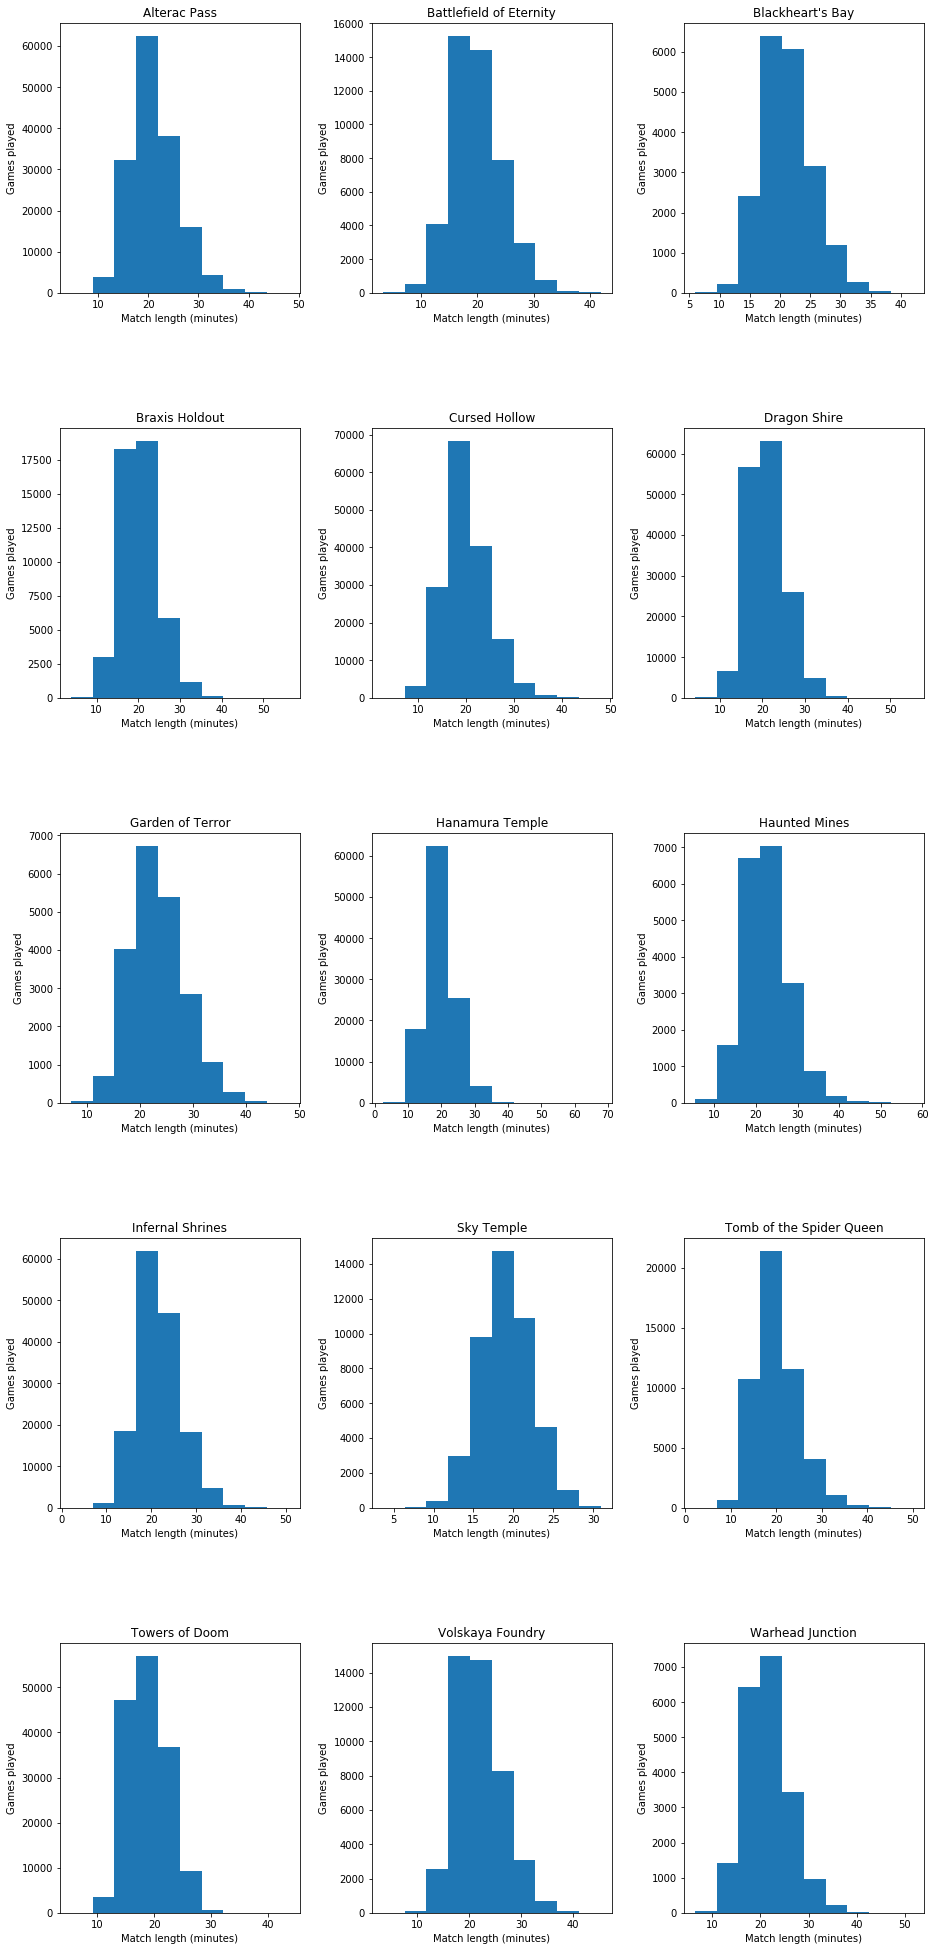

In [88]:
fig, ax = plt.subplots(5, 3, figsize=(15, 35))
for axis in itertools.chain(*ax):
    axis.set_xlabel("Match length (minutes)")
    axis.set_ylabel("Games played")
    
match_lengths["length_mins"].hist(by=match_lengths["name"], rot=0, ax=ax)

plt.show()